In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import local_binary_pattern, hog
import random



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Images From Train/Test Folders
def load_split_dataset(base_path):
    X_images, y_labels = [], []
    for label in os.listdir(base_path):
        label_folder = os.path.join(base_path, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    X_images.append(img)
                    y_labels.append(label)
    return np.array(X_images), np.array(y_labels)


In [ ]:
# Feature Extraction (LBP and HOG)
def extract_lbp_features(images):
    features = []
    for img in images:
        lbp = local_binary_pattern(img, P=8, R=1, method='default')
        hist, _ = np.histogram(lbp, bins=np.arange(257), range=(0, 256))
        hist = hist.astype('float32')
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

def extract_hog_features(images):
    features = []
    for img in images:
        hog_vec = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      block_norm='L2-Hys', visualize=False)
        features.append(hog_vec)
    return np.array(features)


In [ ]:
# Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} on {dataset_name} Accuracy: {acc * 100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"{model_name} Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return model


In [ ]:
# Visualize Sample Prediction
def show_predictions(model, X_test, y_test, images, label_encoder):
    idxs = random.sample(range(len(X_test)), 3)
    for idx in idxs:
        img = images[idx]
        true_label = label_encoder.inverse_transform([y_test[idx]])[0]
        pred_label = label_encoder.inverse_transform([model.predict([X_test[idx]])[0]])[0]
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}, Predicted: {pred_label}")
        plt.axis('off')
        plt.show()


In [8]:
# Load and Prepare Datasets
# Set paths for training and testing folders for CK+
train_folder_path_ck = "/content/drive/My Drive/CK_dataset/CK_dataset/train"
test_folder_path_ck = "/content/drive/My Drive/CK_dataset/CK_dataset/test"
# Set paths for training and testing folders for JAFFE
train_folder_path_jaffe = "/content/drive/My Drive/JAFFE-[70,30]/JAFFE-[70,30]/train"
test_folder_path_jaffe = "/content/drive/My Drive/JAFFE-[70,30]/JAFFE-[70,30]/test"

# Load image data
X_train_jaffe_img, y_train_jaffe_raw = load_split_dataset(train_folder_path_jaffe)
X_test_jaffe_img, y_test_jaffe_raw = load_split_dataset(test_folder_path_jaffe)
X_train_ck_img, y_train_ck_raw = load_split_dataset(train_folder_path_ck)
X_test_ck_img, y_test_ck_raw = load_split_dataset(test_folder_path_ck)

# Encode labels
le = LabelEncoder()
y_train_jaffe = le.fit_transform(y_train_jaffe_raw)
y_test_jaffe = le.transform(y_test_jaffe_raw)
y_train_ck = le.fit_transform(y_train_ck_raw)
y_test_ck = le.transform(y_test_ck_raw)

# Feature extraction
X_train_jaffe_feat = extract_hog_features(X_train_jaffe_img)
X_test_jaffe_feat = extract_hog_features(X_test_jaffe_img)
X_train_ck_feat = extract_lbp_features(X_train_ck_img)
X_test_ck_feat = extract_lbp_features(X_test_ck_img)


SVM + HOG on JAFFE Accuracy: 49.09%


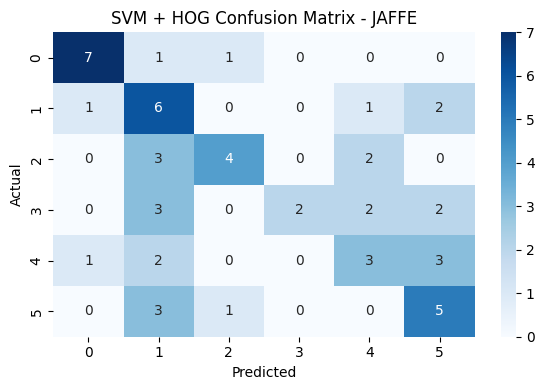

Decision Tree + LBP on CK+ Accuracy: 37.76%


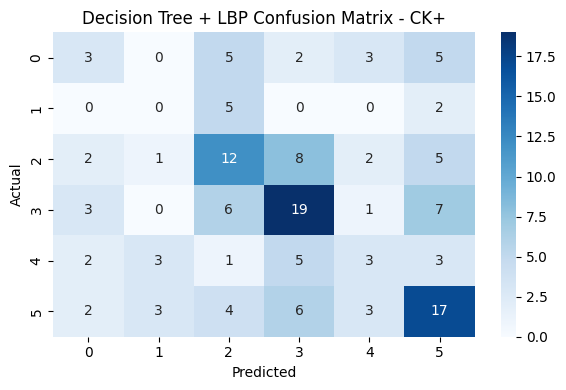

In [9]:
# Train and Evaluate Models
# Define classifiers
svm_model = SVC(kernel='linear', class_weight='balanced')
dt_model = DecisionTreeClassifier(random_state=42)


# JAFFE → HOG + SVM
model_jaffe = evaluate_model(svm_model, X_train_jaffe_feat, y_train_jaffe, X_test_jaffe_feat, y_test_jaffe, "SVM + HOG", "JAFFE")
# CK+ → LBP + Decision Tree
model_ck = evaluate_model(dt_model, X_train_ck_feat, y_train_ck, X_test_ck_feat, y_test_ck, "Decision Tree + LBP", "CK+")

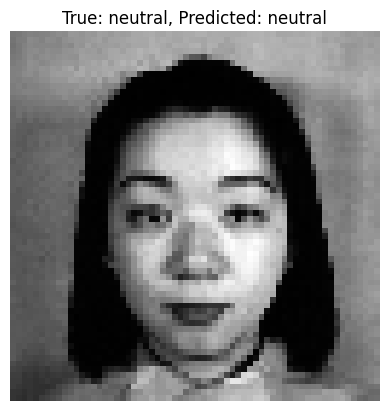

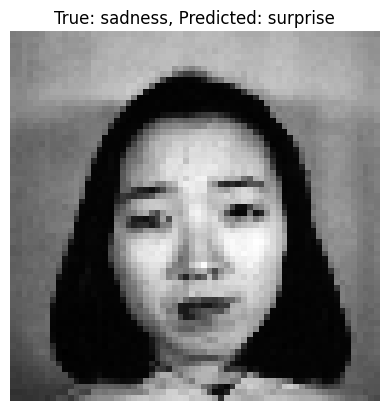

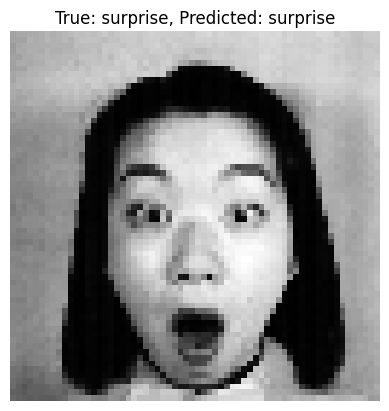

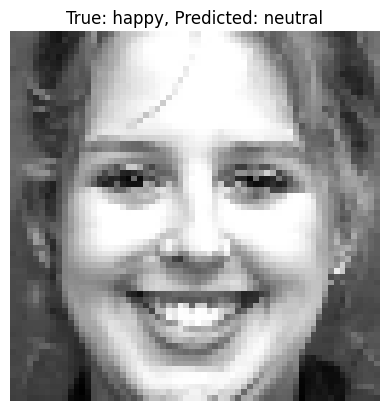

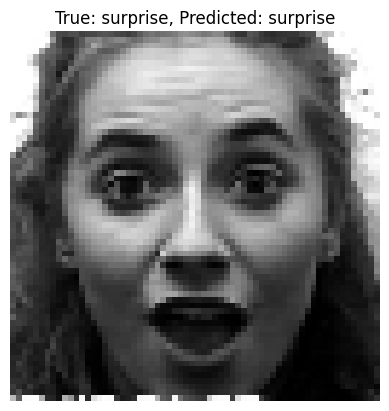

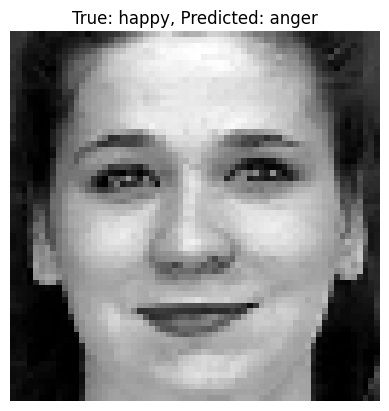

In [10]:
# Visualize 3 Prediction per Dataset
show_predictions(model_jaffe, X_test_jaffe_feat, y_test_jaffe, X_test_jaffe_img, le)
show_predictions(model_ck, X_test_ck_feat, y_test_ck, X_test_ck_img, le)


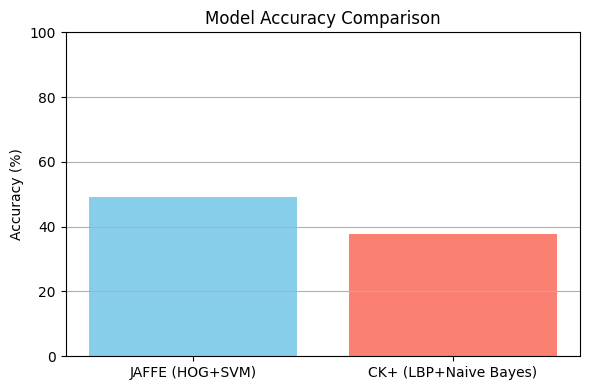

In [11]:
# Accuracy Comparison Bar Chart
# Store accuracy values manually based on previous output
acc_jaffe = accuracy_score(y_test_jaffe, model_jaffe.predict(X_test_jaffe_feat))
acc_ck = accuracy_score(y_test_ck, model_ck.predict(X_test_ck_feat))

# Plotting the bar chart
plt.figure(figsize=(6,4))
datasets = ['JAFFE (HOG+SVM)', 'CK+ (LBP+Naive Bayes)']
accuracies = [acc_jaffe * 100, acc_ck * 100]

plt.bar(datasets, accuracies, color=['skyblue', 'salmon'])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
